# Pros and cons of image file formats
When working with microscopy image data, many file formats are circulating. Most microscope vendors bring proprietary image file formats, image analysis software vendors offer custom and partially open file formats. Traditional file formats exist as well which are supported by common python libraries. For general-purpose image storage, only very few image file formats such as [TIF](https://en.wikipedia.org/wiki/TIFF) can be recommended. Furthermore, formats such as [JPEG](https://en.wikipedia.org/wiki/JPEG) should be avoided to conserve image data integrity. In this notebook we will test some file formats by resaving a microscopy image in these formats, reloading the image and comparing the images before and after saving.

See also
* [ImageIO](https://github.com/imageio/imageio)
* [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio)
* [python-bioformats](https://github.com/CellProfiler/python-bioformats)
* [Moore et al. Nat Methods (2021) "OME-NGFF: a next-generation file format for expanding bioimaging data-access strategies"](https://www.nature.com/articles/s41592-021-01326-w)

In [1]:
from skimage.data import cells3d
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings

As example image we use the [Cells 3D](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.cells3d) example image of scikit-image which was provided by the Allen Institute for Cell Science. It is an unsigned integer 16-bit image. In the first attempt we will choose only a single channel and plane.

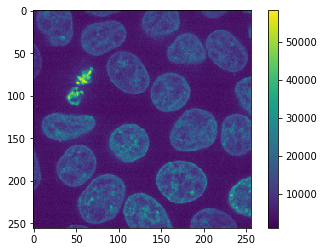

In [2]:
original_image = cells3d()[30, 1]
cle.imshow(original_image, colorbar=True)

## Why JPEG should be avoided
The JPEG file format is, at least per default in may programs, a lossy file format. That means information is lost when saving the image.

In [3]:
imsave("temp.jpg", original_image)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


The warning above confirms this. Furthermore, when we reload the image, we can see in the colorbar that the intensity range is different now.

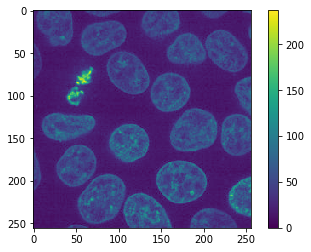

In [4]:
jpg_image = imread("temp.jpg")

cle.imshow(jpg_image, colorbar=True)

Furthermore, if we zoom in, we can see two kind of typical JPEG artifacts.
* The image is denoised.
* We see patches, e.g. 8x8 pixels large and stripes going in different directions.

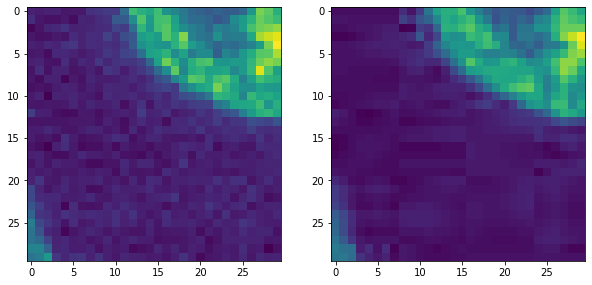

In [5]:
fix, axs = plt.subplots(1,2,figsize=(10,10))

cle.imshow(original_image[140:170, 0:30], plot=axs[0])
cle.imshow(jpg_image[140:170, 0:30], plot=axs[1])

To investigate those errors quantitatively and also to test multiple file formats, we write a short function that saves and reloads the image and outputs a table with some measurements,

In [6]:
def resave_image_statistics(original_image):
    """Saves and reloads an image in multiple formats and returns a table with image statistics."""

    # prepare table
    stats = {
        "ending":[],
        "data_type":[],
        "shape":[],
        "size":[],
        "min":[],
        "max":[],
        "mean":[],
        "standard_deviation":[],
        "mean_squared_error":[],
    }
    
    # go through different file endings
    endings = [None, "tif","png","mhd","mha","jpg","gif","bmp"]
    for ending in endings:
        try:
            if ending is None:
                # use the original image as first test
                reloaded_image = original_image
                size = np.NaN
            else:
                # save and reload image
                filename = "temp." + ending
                imsave(filename, original_image)

                reloaded_image = imread(filename)
                size = os.path.getsize(filename)
            
            # determine statistics
            stats["ending"].append(ending)
            stats["data_type"].append(reloaded_image.dtype)
            stats["shape"].append(reloaded_image.shape)
            stats["size"].append(size)
            stats["min"].append(np.min(reloaded_image))
            stats["max"].append(np.max(reloaded_image.astype(float)))
            stats["mean"].append(np.mean(reloaded_image))
            stats["standard_deviation"].append(np.std(reloaded_image))

            stats["mean_squared_error"].append(np.mean((original_image - reloaded_image)**2))

        except ValueError:
            # some formats are not supported
            warnings.warn("File format not supported: " + ending)
            pass

    return pd.DataFrame(stats)

Next, we apply that function to a 2D image slice.

In [7]:
resave_image_statistics(cells3d()[30, 1])

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


,ending,data_type,shape,size,min,max,mean,standard_deviation,mean_squared_error
0,None,uint16,"(256, 256)",NaN,1091,58327.0,9346.115417,6139.322637,0.000000
1,tif,uint16,"(256, 256)",131328.0,1091,58327.0,9346.115417,6139.322637,0.000000
2,png,uint16,"(256, 256)",107470.0,1091,58327.0,9346.115417,6139.322637,0.000000
3,mhd,uint16,"(256, 256)",281.0,1091,58327.0,9346.115417,6139.322637,0.000000
4,mha,uint16,"(256, 256)",131350.0,1091,58327.0,9346.115417,6139.322637,0.000000
5,jpg,uint8,"(256, 256)",9271.0,0,237.0,36.005875,23.824527,32596.059555
6,gif,uint8,"(256, 256)",58225.0,4,227.0,36.014725,23.978329,32236.271164
7,bmp,uint8,"(256, 256)",66614.0,4,227.0,36.014725,23.978329,32236.271164


## Saving 3D images
We can use the same function to test which file formats support 3D images.

In [8]:
resave_image_statistics(cells3d()[30])

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


,ending,data_type,shape,size,min,max,mean,standard_deviation,mean_squared_error
0,None,uint16,"(2, 256, 256)",NaN,277,58327.0,5925.968422,5711.584119,0.0
1,tif,uint16,"(2, 256, 256)",262566.0,277,58327.0,5925.968422,5711.584119,0.0


## Saving 4D images
The `cells3d` dataset is actually a 4D-dataset. It contains channels as well. Thus, we can use it to test saving and reloading 4D data as well.

In [9]:
resave_image_statistics(cells3d())

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


,ending,data_type,shape,size,min,max,mean,standard_deviation,mean_squared_error
0,None,uint16,"(60, 2, 256, 256)",NaN,0,65535.0,4837.14054,3985.348828,0.0
1,tif,uint16,"(60, 2, 256, 256)",15748650.0,0,65535.0,4837.14054,3985.348828,0.0


Thus, the TIF file format can be recommended. It is also compatible with a wide range of other software such as [ImageJ](https://imagej.net) and [Fiji](https://fiji.sc).

## Exercise
Determine if the file formats 'ico' and 'raw' are supported.